In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

In [5]:
df = pd.read_csv('/content/creditcard.csv')
df['Amount_log'] = np.log1p(df['Amount'])
df.drop(['Time', 'Amount'], axis=1, inplace=True)

In [6]:
X = df.drop('Class', axis=1)
y = df['Class']

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [8]:
def make_dataset(X, y, batch_size=2048, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [9]:
train_ds = make_dataset(X_train, y_train)
val_ds = make_dataset(X_val, y_val, shuffle=False)
test_ds = make_dataset(X_test, y_test, shuffle=False)

In [15]:
all_inputs = []
encoded_features = []

In [16]:
for col in X.columns:
    numeric_col = tf.keras.Input(shape=(1,), name=col)
    normalization_layer = tf.keras.layers.Normalization()
    normalization_layer.adapt(np.array(X_train[col]).reshape(-1, 1))  # fit only on train
    encoded_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_col)

In [17]:
all_features = tf.keras.layers.concatenate(encoded_features)

In [30]:
x = tf.keras.layers.Dense(128, activation='relu')(all_features)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [31]:
model = tf.keras.Model(inputs=all_inputs, outputs=output)

In [32]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(name='auc')
    ]
)

In [33]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=10,
    mode='max',
    restore_best_weights=True
)

In [34]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - auc: 0.6330 - loss: 0.3971 - precision_2: 0.0071 - recall_2: 0.4889 - val_auc: 0.8099 - val_loss: 0.0877 - val_precision_2: 0.7313 - val_recall_2: 0.6622
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - auc: 0.8332 - loss: 0.0219 - precision_2: 0.4612 - recall_2: 0.5431 - val_auc: 0.8897 - val_loss: 0.0174 - val_precision_2: 0.7123 - val_recall_2: 0.7027
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - auc: 0.9158 - loss: 0.0112 - precision_2: 0.6338 - recall_2: 0.6022 - val_auc: 0.9088 - val_loss: 0.0071 - val_precision_2: 0.7391 - val_recall_2: 0.6892
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - auc: 0.9241 - loss: 0.0083 - precision_2: 0.7983 - recall_2: 0.6749 - val_auc: 0.9037 - val_loss: 0.0056 - val_precision_2: 0.7534 - val_recall_2: 0.7432
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - auc: 0.9304 - loss: 0.0066 - precision_2: 0.8330 - recall_2: 0.6835 - val_auc: 0.9111 - val_loss: 0.0047 - val_pr

In [35]:
y_pred_proba = model.predict(dict(X_test)).ravel()
y_pred = (y_pred_proba >= 0.5).astype(int)

1336/1336 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [37]:
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

ROC AUC Score: 0.9717153492828788


In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42648
           1       0.92      0.77      0.84        74

    accuracy                           1.00     42722
   macro avg       0.96      0.89      0.92     42722
weighted avg       1.00      1.00      1.00     42722



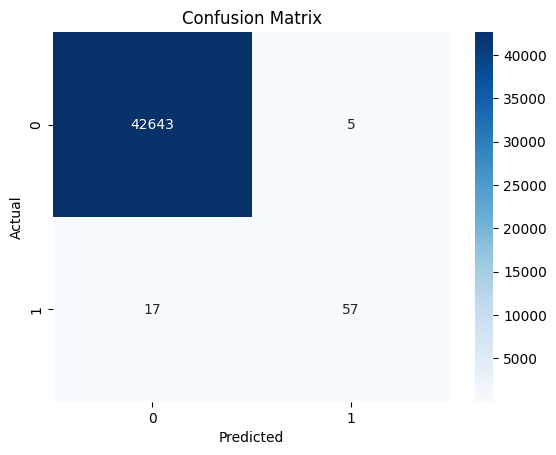

In [39]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()